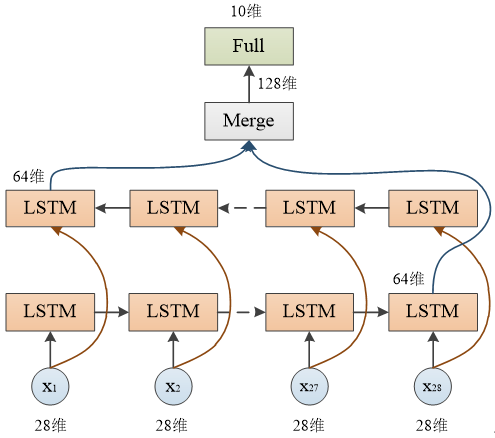

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
from tqdm import tqdm

filepath = 'rlData.csv'
data = pd.read_csv(filepath)
data = data.sort_values('Date')
price = data[['Open','High','Low','Close','Adj Close','Volume']].copy() 


scaler = MinMaxScaler(feature_range=(0, 1))
price_scaled = scaler.fit_transform(price)
price_df = pd.DataFrame(price_scaled, columns=['Open','High','Low','Close','Adj Close','Volume'])  # 转换为DataFrame，方便后续操作

def split_data(stock, lookback, num_steps):  
    # 确保lookback大于或等于num_steps
    assert lookback >= num_steps
    
    # 将stock转化为ndarray类型  
    data_raw = stock.to_numpy()  # 假设stock是DataFrame，只含有一个特征列
    data = []  
  
    # 将data按lookback分组  
    for index in range(len(data_raw) - lookback):  # 注意这里要减去num_steps-1  
        data.append(data_raw[index: index + lookback])  
  
    data = np.array(data)  
      
    # 按照8:2进行训练集、测试集划分  
    test_set_size = int(np.round(0.2 * data.shape[0]))  
    train_set_size = data.shape[0] - test_set_size  
      
    x_train = data[:train_set_size, :-num_steps, :]  
    y_train = data[:train_set_size, -num_steps:, :]  # 取最后num_steps个时间步作为目标值  
  
    x_test = data[train_set_size:, :-num_steps, :]  
    y_test = data[train_set_size:, -num_steps:, :]  
  
    return [x_train, y_train, x_test, y_test]  

In [12]:
# 样本长度
lookback = 20
# 要预测的未来时间步数量, 样本长度要>>预测时间步数
num_steps = 1  
x_train, y_train, x_test, y_test = split_data(price_df, lookback, num_steps)

In [13]:
x_train.shape

(186, 19, 6)

In [14]:
y_train.shape

(186, 1, 6)

In [15]:
price_df.shape

(252, 6)

In [16]:
print(type(y_train))

<class 'numpy.ndarray'>


In [17]:
# 将 NumPy 数组转换为 PyTorch Tensor
x_train = torch.from_numpy(x_train).float()  # 假设数据是浮点数
y_train = torch.from_numpy(y_train).float()
x_test = torch.from_numpy(x_test).float()
y_test = torch.from_numpy(y_test).float()

In [18]:
# 创建数据加载器
# train_dataset = TensorDataset(x_train, y_train)
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# val_dataset = TensorDataset(x_test, y_test)
# val_loader = DataLoader(val_dataset, batch_size=32)

# 定义Bidirectional LSTM模型
class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(BiLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        #设置了参数bidirectional=True。这意味着LSTM层将分别处理输入序列的前向和后向
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size*2, output_size)  # 双向LSTM的输出大小是隐藏层大小的2倍
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(x.device) # 2 for bidir
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size*2)
        out = self.fc(out[:, -1, :])  # 取最后一个时间步的输出
        return out

In [19]:
# 初始化模型和优化器
input_size = 6
hidden_size = 32
num_layers = 1
output_size = 6  # 预测下一个时间点的股票价格
model = BiLSTM(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()  # 使用均方误差损失（MSE）作为回归损失
optimizer = optim.Adam(model.parameters(), lr=0.001)


val_loss_history = []
train_loss_history = []  # 添加这一行来记录训练损失

# 训练模型（这里省略了完整的训练循环，只给出大致结构）
num_epochs = 200

running_loss = 0.0  # 用于记录一个epoch内的训练损失

for epoch in range(num_epochs):
    model.train()  # 实际上这一行在循环开始前已经设置过了，可以省略

    # 前向传播
    optimizer.zero_grad()  # 清空梯度（这行代码通常放在前向传播之前）
    outputs = model(x_train)
    loss = criterion(outputs, y_train)
    
    # 反向传播和优化
    loss.backward()  # 反向传播计算梯度
    optimizer.step()  # 使用梯度更新权重
        
    # 计算平均训练损失
    train_loss_history.append(loss.item())
    
    # 验证步骤
    model.eval()  # 设置模型为评估模式（关闭dropout等）
    val_loss = 0.0  # 初始化验证损失
    with torch.no_grad():  # 不需要计算梯度
        val_outputs = model(x_test)
        val_loss = criterion(val_outputs, y_test).item()
    val_loss_history.append(val_loss)
    
    # 输出统计信息
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss:.4f}, Val Loss: {val_loss:.4f}')

# 训练结束后，可以绘制损失折线图
# 这里省略了绘制损失折线图的代码，你可以使用matplotlib等库来绘制

Epoch [1/200], Train Loss: 0.1503, Val Loss: 0.2364
Epoch [2/200], Train Loss: 0.1453, Val Loss: 0.2282


d:\Anaconda\envs\DL\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([186, 1, 6])) that is different to the input size (torch.Size([186, 6])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
d:\Anaconda\envs\DL\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([46, 1, 6])) that is different to the input size (torch.Size([46, 6])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [3/200], Train Loss: 0.1406, Val Loss: 0.2202
Epoch [4/200], Train Loss: 0.1360, Val Loss: 0.2123
Epoch [5/200], Train Loss: 0.1316, Val Loss: 0.2047
Epoch [6/200], Train Loss: 0.1273, Val Loss: 0.1971
Epoch [7/200], Train Loss: 0.1231, Val Loss: 0.1897
Epoch [8/200], Train Loss: 0.1190, Val Loss: 0.1823
Epoch [9/200], Train Loss: 0.1149, Val Loss: 0.1749
Epoch [10/200], Train Loss: 0.1110, Val Loss: 0.1676
Epoch [11/200], Train Loss: 0.1071, Val Loss: 0.1603
Epoch [12/200], Train Loss: 0.1033, Val Loss: 0.1529
Epoch [13/200], Train Loss: 0.0996, Val Loss: 0.1456
Epoch [14/200], Train Loss: 0.0959, Val Loss: 0.1382
Epoch [15/200], Train Loss: 0.0923, Val Loss: 0.1308
Epoch [16/200], Train Loss: 0.0887, Val Loss: 0.1234
Epoch [17/200], Train Loss: 0.0853, Val Loss: 0.1160
Epoch [18/200], Train Loss: 0.0819, Val Loss: 0.1087
Epoch [19/200], Train Loss: 0.0787, Val Loss: 0.1013
Epoch [20/200], Train Loss: 0.0756, Val Loss: 0.0941
Epoch [21/200], Train Loss: 0.0727, Val Loss: 0.0870


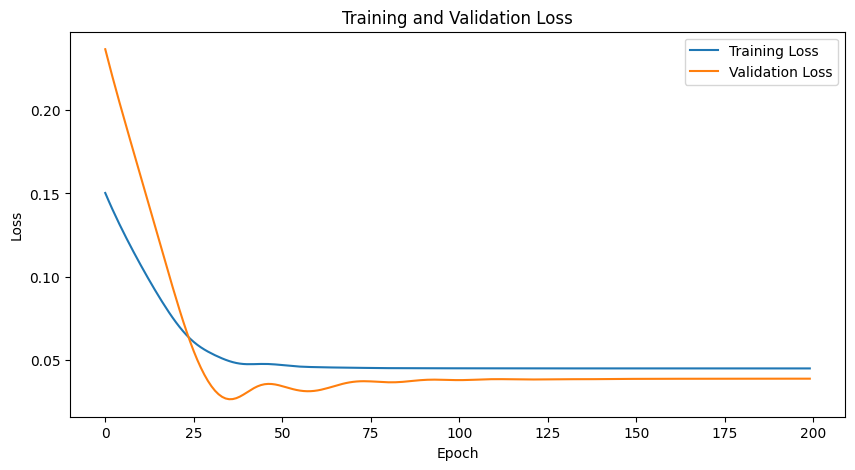

In [20]:
import matplotlib.pyplot as plt

# 绘制损失图
plt.figure(figsize=(10, 5))
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()